In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

class LoadData:
    def __init__(self, file_path):
        self.file_path = file_path

    def load_data(self):
        data = pd.read_csv(self.file_path)
        return data

    def prepare_data(self, data):
        # Eliminar columnas irrelevantes
        data = data.drop(['idPartido', 'Ronda', 'Temporada', 'Evento', 'GolesLocal', 'GolesVisitante'], axis=1)

        # Separar características y etiquetas
        X = data.drop(['VictoriaLocal', 'Empate', 'VictoriaVisitante'], axis=1)
        y = data[['VictoriaLocal', 'Empate', 'VictoriaVisitante']]

        # Escalar características
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Dividir los datos en conjuntos de entrenamiento y prueba
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
        
        # Convertir los datos a tensores
        X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
        X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
        y_train = tf.convert_to_tensor(y_train.values, dtype=tf.float32)
        y_test = tf.convert_to_tensor(y_test.values, dtype=tf.float32)
        
        return X_train, X_test, y_train, y_test, scaler, X, y
    
data = LoadData('dataframe/champions.csv')
X_train, X_test, y_train, y_test, scaler, X, y = data.prepare_data(data.load_data())

In [10]:
'''Ajuste de hiperparámetros'''

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

class Model:
    def __init__(self, configurations):
        self.configurations = configurations
        self.best_model = None
        self.best_config = None
        self.best_accuracy = 0

    def train_model(self, X_train, y_train):
        for config in self.configurations:
            model = Sequential([
                Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)),
                Conv1D(config['filters'], config['kernel_size'], activation='relu'),
                MaxPooling1D(),
                Flatten(),
                Dense(config['units'], activation='relu'),
                Dropout(config['dropout']),
                Dense(3, activation='softmax')
            ])

            optimizer = Adam(learning_rate=config['learning_rate'])
            model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

            history = model.fit(X_train, y_train, epochs=config['epochs'], batch_size=config['batch_size'], validation_split=0.1)
            
            self.history = history
            _, accuracy = model.evaluate(X_test, y_test)
            
            if accuracy > self.best_accuracy:
                self.best_accuracy = accuracy
                self.best_model = model
                self.best_config = config
    
    def get_best_model(self):
        return self.best_model
    
    def get_best_config(self):
        return self.best_config



# Definir diferentes configuraciones de red y hiperparámetros
configurations = [
    {'units': 64, 'filters': 32, 'kernel_size': 3, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 10, 'dropout': 0.2},
    {'units': 128, 'filters': 64, 'kernel_size': 3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 15, 'dropout': 0.1},
    {'units': 256, 'filters': 128, 'kernel_size': 5, 'learning_rate': 0.0001, 'batch_size': 16, 'epochs': 10, 'dropout': 0.3},
    {'units': 64, 'filters': 32, 'kernel_size': 3, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 20, 'dropout': 0.3},
    {'units': 128, 'filters': 64, 'kernel_size': 5, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 15, 'dropout': 0.2},
    {'units': 256, 'filters': 128, 'kernel_size': 3, 'learning_rate': 0.0005, 'batch_size': 32, 'epochs': 10, 'dropout': 0.1},
    {'units': 64, 'filters': 32, 'kernel_size': 5, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 10, 'dropout': 0.1},
    {'units': 128, 'filters': 64, 'kernel_size': 3, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 20, 'dropout': 0.2},
    {'units': 256, 'filters': 128, 'kernel_size': 5, 'learning_rate': 0.0005, 'batch_size': 32, 'epochs': 15, 'dropout': 0.2},
]


model_trainer = Model(configurations)
model_trainer.train_model(X_train, y_train)

model = model_trainer.get_best_model()
best_config = model_trainer.get_best_config()
print("Mejor configuración:", best_config)


Epoch 1/10


/Users/carlotasanchezgonzalez/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5071 - loss: 1.0115 - val_accuracy: 0.5657 - val_loss: 0.9760
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - accuracy: 0.5896 - loss: 0.9382 - val_accuracy: 0.5714 - val_loss: 0.9543
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - accuracy: 0.5740 - loss: 0.9419 - val_accuracy: 0.5943 - val_loss: 0.9323
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - accuracy: 0.6092 - loss: 0.8952 - val_accuracy: 0.6286 - val_loss: 0.9176
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step - accuracy: 0.5968 - loss: 0.8956 - val_accuracy: 0.6000 - val_loss: 0.9261
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - accuracy: 0.6000 - loss: 0.8839 - val_accuracy: 0.5829 - val_loss: 0.9299
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - accuracy: 0.5901 - loss: 0.8909 - val_accuracy: 0.5943 - val_loss: 0.9267
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - accuracy: 0.6091 - loss: 0.8775 - val_accuracy: 0.6000 - val_lo

 1/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.8703

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6744 - loss: 0.8269
Loss: 0.8491290211677551
Accuracy: 0.6542056202888489
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Confusion Matrix:
[[314   7  51]
 [ 65  11  73]
 [ 53  10 165]]


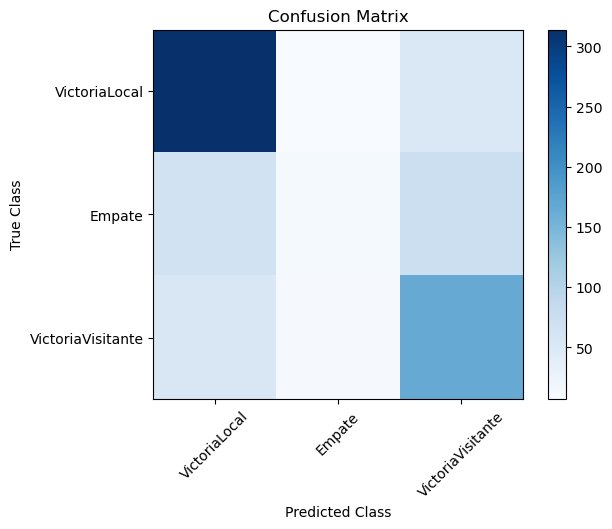

In [11]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

class ModelEvaluation:
    def __init__(self, model):
        self.model = model
    
    def evaluate_model(self, X_test, y_test, class_labels):
        # Evaluar el modelo
        loss, accuracy = model.evaluate(X_test, y_test)
        print("Loss:", loss)
        print("Accuracy:", accuracy)

        # Generar predicciones
        class_probabilities = model.predict(X_test)
        predictions = np.argmax(class_probabilities, axis=1)
        true_labels = np.argmax(y_test, axis=1)

        # Calcular y mostrar la matriz de confusión
        conf_matrix = confusion_matrix(true_labels, predictions)
        print("Confusion Matrix:")
        print(conf_matrix)

        self.plot_matriz_confusion(conf_matrix, class_labels)

    def plot_matriz_confusion(self, conf_matrix, class_labels):
        # Visualizar la matriz de confusión
        plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
        plt.colorbar()
        tick_marks = np.arange(len(class_labels))
        plt.xticks(tick_marks, class_labels, rotation=45)
        plt.yticks(tick_marks, class_labels)
        plt.xlabel("Predicted Class")
        plt.ylabel("True Class")
        plt.title("Confusion Matrix")
        plt.show()


model_evaluator = ModelEvaluation(model)
model_evaluator.evaluate_model(X_test, y_test, y.columns)



In [13]:
import matplotlib.pyplot as plt

def plot_learning_curve_tf(history):
    """
    Función para visualizar las curvas de aprendizaje de un modelo TensorFlow.
    
    Parameters:
        history: El objeto history devuelto por el método fit del modelo de TensorFlow.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    epochs = range(1, len(train_loss) + 1)
    
    plt.figure(figsize=(20, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, 'r', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()

# Utiliza la función plot_learning_curve_tf con el historial de entrenamiento de tu modelo
plot_learning_curve_tf(history)



NameError: name 'history' is not defined

In [ ]:
# Guardar el modelo
tf.keras.models.save_model(model, 'modelos/modelo_redes_CNN.keras')


In [ ]:
model = tf.keras.models.load_model("modelos/modelo_redes_CNN.keras")

In [ ]:
import pandas as pd

# Cargar los datos
df = pd.read_csv("dataframe/champions_23_24.csv")

df

# Ahora puedes utilizar estas estadísticas para predecir el resultado del partido utilizando tu modelo de red neuronal


,idPartido,Temporada,Ronda,Local,Visitante,Evento,GolesLocal,GolesVisitante,VictoriaLocal,Empate,...,1_MediaJugadores,%_2_G_Temporada,%_2_G_Temporada_L,%_2_E_Temporada_L,%_2_P_Temporada_L,2_Media_G,2_Media_G_Local,2_Media_Goles_PP,2_ValorJugadores,2_MediaJugadores
0,1,2023-01-01,Group stage,2,307,Stadio Giuseppe Meazza,0,0,0,1,...,16.423147,20.00,33.33,0.00,66.67,0.20,0.33,1.20,385.648621,16.767331
1,2,2023-01-01,Group stage,67,68,Stadion Wankdorf,1,3,0,0,...,15.543811,42.86,50.00,0.00,50.00,0.43,0.50,1.57,497.803882,21.643647
2,3,2023-01-01,Group stage,16,20,Etihad Stadium,3,1,1,0,...,23.287028,0.00,0.00,33.33,66.67,0.00,0.00,1.20,374.821246,17.037329
3,4,2023-01-01,Group stage,28,14,Parc des Princes,2,0,1,0,...,26.475023,44.44,40.00,60.00,0.00,0.44,0.40,1.11,501.021450,21.783541
4,5,2023-01-01,Group stage,99,24,Stadio Olimpico,1,1,0,1,...,24.959872,44.44,60.00,20.00,20.00,0.44,0.60,2.00,550.408580,25.018572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,116,2023-01-01,Quarter-finals,28,5,Parc des Princes,0,0,0,1,...,26.475023,55.56,80.00,20.00,0.00,0.56,0.80,1.78,556.384065,22.255363
116,117,2023-01-01,Quarter-finals,5,28,Estadi Olímpic Lluís Companys,0,0,0,1,...,22.255363,44.44,60.00,40.00,0.00,0.44,0.60,1.44,555.975485,26.475023
117,118,2023-01-01,Quarter-finals,14,24,Signal Iduna Park,0,0,0,1,...,21.783541,44.44,60.00,20.00,20.00,0.44,0.60,2.11,550.408580,25.018572
118,119,2023-01-01,Quarter-finals,16,1,Etihad Stadium,0,0,0,1,...,23.287028,77.78,60.00,40.00,0.00,0.78,0.60,2.00,549.336057,26.158860


In [ ]:
# 1. Pedir al usuario que ingrese el equipo local
print("Seleccione el equipo local:")
equipos_disponibles = df['Local'].unique()
equipos_disponibles

equipo_local = int(input("Ingrese el nombre del equipo local: "))
equipo_visitante = int(input("Ingrese el nombre del equipo visitante: "))


# Filtrar el DataFrame para obtener la última fila donde el equipo local y visitante coincidan con los ingresados por el usuario
filtro_ultimo_partido = ((df['Local'] == equipo_local) & (df['Visitante'] == equipo_visitante)) | ((df['Local'] == equipo_visitante) & (df['Visitante'] == equipo_local))

# Obtener el último partido entre los equipos ingresados por el usuario
ultimo_partido_entre_equipos = df[filtro_ultimo_partido].iloc[-1]

# Obtener los valores para las columnas %_Victorias_Local, %_Empate, %_Victoria_Visitante
valores_prediccion = ultimo_partido_entre_equipos[['%_Victorias_Local', '%_Empate', '%_Victoria_Visitante']]

if ultimo_partido_entre_equipos['Local'] == equipo_local and ultimo_partido_entre_equipos['Visitante'] == equipo_visitante:
    porcentajes_de_los_dos = ultimo_partido_entre_equipos[['%_Equipo1_Ganado', '%_Equipo2_Ganado']]

elif ultimo_partido_entre_equipos['Local'] == equipo_visitante and ultimo_partido_entre_equipos['Visitante'] == equipo_local:
    porcentajes_de_los_dos = ultimo_partido_entre_equipos[['%_Equipo1_Ganado', '%_Equipo2_Ganado']]
    porcentajes_de_los_dos.column = ['%_Equipo2_Ganado', '%_Equipo1_Ganado']


# 3. Filtrar el DataFrame para obtener las estadísticas del equipo local
filtro_local = (df['Local'] == equipo_local) | (df['Visitante'] == equipo_local)
ultima_aparicion_local = df[filtro_local].iloc[-1]
if ultima_aparicion_local['Local'] == equipo_local:
    estadisticas_equipo_local = ultima_aparicion_local[['%_1_G_Temporada', '%_1_G_Temporada_L', '%_1_E_Temporada_L', '%_1_P_Temporada_L', '1_Media_G', '1_Media_G_Local', '1_Media_Goles_PP', '1_ValorJugadores', '1_MediaJugadores']]
else:
    estadisticas_equipo_local = ultima_aparicion_local[['%_2_G_Temporada', '%_2_G_Temporada_L', '%_2_E_Temporada_L', '%_2_P_Temporada_L', '2_Media_G', '2_Media_G_Local', '2_Media_Goles_PP', '2_ValorJugadores', '2_MediaJugadores']]
    #Cambiar el numero del nombre de las columnas porque si es el local del usuario pasara a ser las columnas con 1 en vez de 2
    estadisticas_equipo_local.columns = ['%_1_G_Temporada', '%_1_G_Temporada_L', '%_1_E_Temporada_L', '%_1_P_Temporada_L', '1_Media_G', '1_Media_G_Local', '1_Media_Goles_PP', '1_ValorJugadores', '1_MediaJugadores']

# 4. Filtrar el DataFrame para obtener las estadísticas del equipo visitante
filtro_visitante = (df['Local'] == equipo_visitante) | (df['Visitante'] == equipo_visitante)
ultima_aparicion_visitante = df[filtro_visitante].iloc[-1]
if ultima_aparicion_visitante['Local'] == equipo_visitante:
    estadisticas_equipo_visitante = ultima_aparicion_visitante[['%_1_G_Temporada', '%_1_G_Temporada_L', '%_1_E_Temporada_L', '%_1_P_Temporada_L', '1_Media_G', '1_Media_G_Local', '1_Media_Goles_PP', '1_ValorJugadores', '1_MediaJugadores']]
    #Cambiar el numero del nombre de las columnas porque si es el visitante del usuario pasara a ser las columnas con 2 en vez de 1
    estadisticas_equipo_local.columns = ['%_2_G_Temporada', '%_2_G_Temporada_L', '%_2_E_Temporada_L', '%_2_P_Temporada_L', '2_Media_G', '2_Media_G_Local', '2_Media_Goles_PP', '2_ValorJugadores', '2_MediaJugadores']
else:
    estadisticas_equipo_visitante = ultima_aparicion_visitante[['%_2_G_Temporada', '%_2_G_Temporada_L', '%_2_E_Temporada_L', '%_2_P_Temporada_L', '2_Media_G', '2_Media_G_Local', '2_Media_Goles_PP', '2_ValorJugadores', '2_MediaJugadores']]



# Combinar las estadísticas de ambos equipos para predecir el resultado del partido
datos_partido = pd.concat([estadisticas_equipo_local, estadisticas_equipo_visitante, valores_prediccion, porcentajes_de_los_dos])


datos_partido


Seleccione el equipo local:


%_1_G_Temporada              88.89
%_1_G_Temporada_L            100.0
%_1_E_Temporada_L              0.0
%_1_P_Temporada_L              0.0
1_Media_G                     0.89
1_Media_G_Local                1.0
1_Media_Goles_PP              2.67
1_ValorJugadores        582.175689
1_MediaJugadores         23.287028
%_2_G_Temporada              77.78
%_2_G_Temporada_L             60.0
%_2_E_Temporada_L             40.0
%_2_P_Temporada_L              0.0
2_Media_G                     0.78
2_Media_G_Local                0.6
2_Media_Goles_PP               2.0
2_ValorJugadores        549.336057
2_MediaJugadores          26.15886
%_Victorias_Local            54.55
%_Empate                     36.36
%_Victoria_Visitante          9.09
%_Equipo1_Ganado             36.36
%_Equipo2_Ganado             27.27
Name: 118, dtype: object

In [ ]:
# Crear un nuevo DataFrame vacío con las columnas especificadas en el orden deseado
nuevo_dataframe = pd.DataFrame(columns=['Local', 'Visitante', '%_Victorias_Local', '%_Empate', '%_Victoria_Visitante',
                                         '%_Equipo1_Ganado', '%_Equipo2_Ganado', '%_1_G_Temporada', '%_1_G_Temporada_L',
                                         '%_1_E_Temporada_L', '%_1_P_Temporada_L', '1_Media_G', '1_Media_G_Local', '1_Media_Goles_PP',
                                         '1_ValorJugadores', '1_MediaJugadores', '%_2_G_Temporada', '%_2_G_Temporada_L',
                                         '%_2_E_Temporada_L', '%_2_P_Temporada_L', '2_Media_G', '2_Media_G_Local', '2_Media_Goles_PP',
                                         '2_ValorJugadores', '2_MediaJugadores'])

# Agregar una fila con los valores proporcionados al nuevo DataFrame
nuevo_dataframe.loc[0] = [equipo_local, equipo_visitante, datos_partido['%_Victorias_Local'], datos_partido['%_Empate'],
                          datos_partido['%_Victoria_Visitante'], datos_partido['%_Equipo1_Ganado'], datos_partido['%_Equipo2_Ganado'],
                          datos_partido['%_1_G_Temporada'], datos_partido['%_1_G_Temporada_L'], datos_partido['%_1_E_Temporada_L'],
                          datos_partido['%_1_P_Temporada_L'], datos_partido['1_Media_G'], datos_partido['1_Media_G_Local'],
                          datos_partido['1_Media_Goles_PP'], datos_partido['1_ValorJugadores'], datos_partido['1_MediaJugadores'],
                          datos_partido['%_2_G_Temporada'], datos_partido['%_2_G_Temporada_L'], datos_partido['%_2_E_Temporada_L'],
                          datos_partido['%_2_P_Temporada_L'], datos_partido['2_Media_G'], datos_partido['2_Media_G_Local'],
                          datos_partido['2_Media_Goles_PP'], datos_partido['2_ValorJugadores'], datos_partido['2_MediaJugadores']]

# Mostrar el nuevo DataFrame
nuevo_dataframe


,Local,Visitante,%_Victorias_Local,%_Empate,%_Victoria_Visitante,%_Equipo1_Ganado,%_Equipo2_Ganado,%_1_G_Temporada,%_1_G_Temporada_L,%_1_E_Temporada_L,...,1_MediaJugadores,%_2_G_Temporada,%_2_G_Temporada_L,%_2_E_Temporada_L,%_2_P_Temporada_L,2_Media_G,2_Media_G_Local,2_Media_Goles_PP,2_ValorJugadores,2_MediaJugadores
0,16.0,1.0,54.55,36.36,9.09,36.36,27.27,88.89,100.0,0.0,...,23.287028,77.78,60.0,40.0,0.0,0.78,0.6,2.0,549.336057,26.15886


In [ ]:
# Escalar características del nuevo DataFrame
X_prediccion = scaler.transform(nuevo_dataframe)

# Realizar predicciones con el modelo
class_probabilities_prediccion = model.predict(X_prediccion)

# Imprimir las probabilidades de clase predichas
print(f"Probabilidades de clase predichas para el partido {equipo_local} VS. {equipo_visitante}:")
for i, prob in enumerate(class_probabilities_prediccion[0]):
    print(f"{y.columns[i]}: {prob:.3f}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Probabilidades de clase predichas para el partido 16 VS. 1:
VictoriaLocal: 0.374
Empate: 0.214
VictoriaVisitante: 0.411
